In [1]:
import pandas as pd
import xarray as xr
import numpy as np
import os
import cartopy.crs as ccrs
from matplotlib import colors as colors
import seaborn as sns; sns.set()
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-white')

import sys  
stdout = sys.stdout
stderr = sys.stderr

reload(sys) # Set default encoding to avoid errors when printing certain strings
sys.setdefaultencoding('utf8')
sys.stdout = stdout # Set output back th the jupyter notebook (otherwise it prints to console)
sys.stderr = stderr
# See: https://stackoverflow.com/questions/25494182/print-not-showing-in-ipython-notebook-python

from IPython.display import HTML

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [3]:
# Pick an index to predict:
INDEX = 'NAO' 

# NAO: North Atlantic Oscillation
# EA: East Atlantic Pattern
# WP: West Pacific Pattern
# EP/NP: EastPacific/ North Pacific Pattern 
# PNA: Pacific/ North American Pattern 
# EA/WR: East Atlantic/West Russia Pattern
# SCA: Scandinavia Pattern 
# TNH: Tropical/ Northern Hemisphere Pattern
# POL: Polar/ Eurasia Pattern
# PT: Pacific Transition Pattern 

In [4]:
# Read in target data: climate indices 
idir = '/media/maffie/MAFFIE2TB/Projects/COI/ObservedIndices/'
idirncep = '/media/maffie/MAFFIE2TB/Projects/COI/NCEP/'
figdir = '/home/maffie/plots/coi/'

idir = './'
idirncep = './'
figdir = './'

In [5]:
indices = pd.read_csv(idir+'tele_index.nh_195001-201709.csv')

In [6]:
indices.head()

yyyy  mm   NAO    EA    WP  EP/NP   PNA  EA/WR   SCA    TNH   POL    PT  \
0  1950   1  0.56 -2.71 -1.69   0.91 -3.65   2.29  0.78   0.55 -0.71 -99.9   
1  1950   2  0.01  0.66 -1.36  -1.13 -1.69  -0.57 -0.94  -1.07  1.25 -99.9   
2  1950   3 -0.78  0.82 -0.38  -0.02 -0.06  -1.80 -0.22 -99.90  0.78 -99.9   
3  1950   4  0.65  0.28 -0.50  -1.87 -0.23  -2.50  0.46 -99.90  0.10 -99.9   
4  1950   5 -0.50 -0.51  0.23  -0.98 -0.40   1.41  0.28 -99.90  0.55 -99.9   

   Expl.Var.  
0       86.0  
1       58.6  
2       54.3  
3       64.8  
4       49.6

In [7]:
# Drop year and month columns, replace with a datetime index
# So that it corresponds with the time dimension in the .nc file with input data
time = pd.date_range(start='1950-01', end='2017-09', freq='MS')
indices = indices.drop(['yyyy', 'mm'], axis=1).set_index(time)

# Set NaNs
indices[indices == -99.90] = np.nan

# Drop columns that we don't need
indices = indices.drop(['Expl.Var.'], axis=1)
indices.head()

NAO    EA    WP  EP/NP   PNA  EA/WR   SCA   TNH   POL  PT
1950-01-01  0.56 -2.71 -1.69   0.91 -3.65   2.29  0.78  0.55 -0.71 NaN
1950-02-01  0.01  0.66 -1.36  -1.13 -1.69  -0.57 -0.94 -1.07  1.25 NaN
1950-03-01 -0.78  0.82 -0.38  -0.02 -0.06  -1.80 -0.22   NaN  0.78 NaN
1950-04-01  0.65  0.28 -0.50  -1.87 -0.23  -2.50  0.46   NaN  0.10 NaN
1950-05-01 -0.50 -0.51  0.23  -0.98 -0.40   1.41  0.28   NaN  0.55 NaN

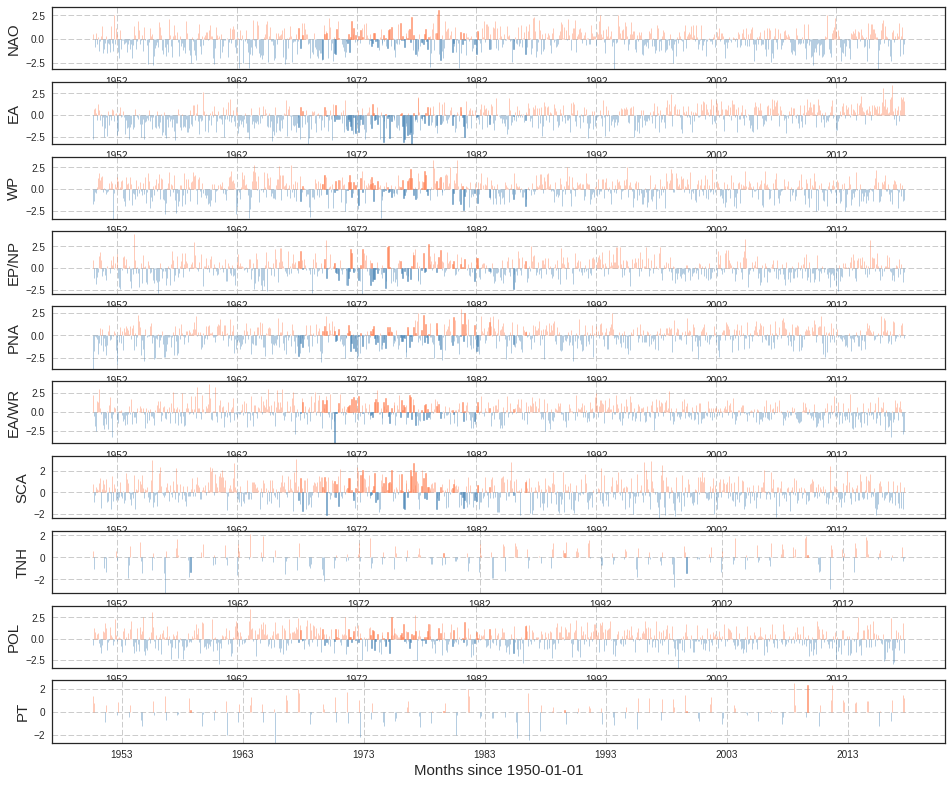

In [8]:
## Plot all indices

widths=1

fig, axes = plt.subplots(len(indices.columns.values),1,figsize=(16,14))
fig.subplots_adjust(bottom=0.15)

count = 0

for coi in list(indices.columns.values):
   
    ax = axes[count]
       
    ax.bar(indices[coi][indices[coi]<=0].index.values,indices[coi][indices[coi]<=0],width=widths, facecolor='steelblue', \
       alpha=.8, edgecolor='steelblue', lw=0.5)

    ax.bar(indices[coi][indices[coi]>0].index.values,indices[coi][indices[coi]>0],width=widths,facecolor='coral', \
       alpha=.8, edgecolor='coral', lw=0.5)

    ax.grid(linestyle='--')
    ax.set_ylabel(coi, fontsize=15, backgroundcolor="w")
    ax.set_xlabel('Months since 1950-01-01', fontsize=15, backgroundcolor="w")
    ax.xaxis.grid(True, which='both')

    count = count + 1
    
plt.savefig(figdir+'Observed_NHTI.jpg',dpi=100,bbox_inches='tight')

In [9]:
# Split in train and test data
y_train_raw = indices[INDEX][:'1999']
y_test_raw = indices[INDEX]['2000':'2016']

# Store location of missing entries to remove them further on
index_missing_train = y_train_raw.isnull()
index_missing_test = y_test_raw.isnull()

# Read in input data: standardized anomalies + absolute pressure values for plotting

data = xr.open_dataset(idirncep+'hgt.mon.mean_stdanom.nc') 
#dataabs = xr.open_dataset(idirncep+'hgt.mon.mean.box.1950-2017.nc') 

# Do the same train-test split

x_train_raw = np.squeeze(np.array(data['hgt'].sel(time=slice('1950','1999'))))
x_test_raw  = np.squeeze(np.array(data['hgt'].sel(time=slice('2000','2016'))))

x_train_flat = np.reshape(x_train_raw, (x_train_raw.shape[0], -1))
x_test_flat = np.reshape(x_test_raw, (x_test_raw.shape[0], -1))

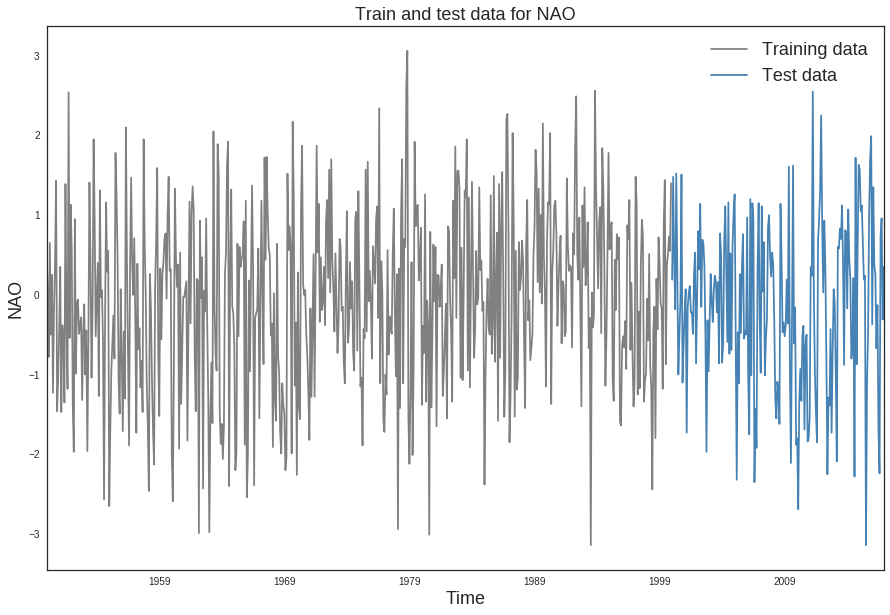

In [10]:
fig, ax = plt.subplots(figsize=(15,10))
y_train_raw.plot(ax=ax, color='grey')
y_test_raw.plot(ax=ax, color='steelblue')
ax.legend(['Training data', 'Test data'], fontsize=18)
ax.set_xlabel('Time').set_fontsize(18)
ax.set_ylabel(INDEX).set_fontsize(18)
ax.set_title('Train and test data for {}'.format(INDEX)).set_fontsize(18)

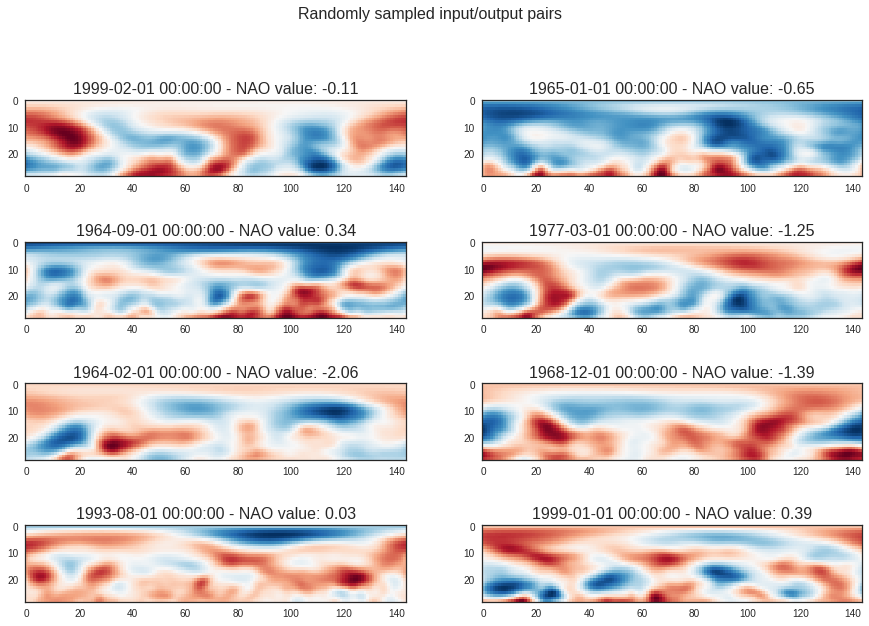

In [11]:
# Plot some input - output pairs

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,10))
for axrow in axes:
    for ax in axrow:
        random_idx = np.random.choice(np.arange(len(y_train_raw)))
        ax.imshow(x_train_raw[random_idx,:,:], cmap='RdBu')
        ax.set_title('{} - {} value: {}'.format(indices.index[random_idx],
                                                INDEX,
                                                y_train_raw[random_idx])).set_fontsize(16)
fig.suptitle('Randomly sampled input/output pairs').set_fontsize(16)

In [12]:
# Function to plot predictions

def plot_predictions(y_test, predictions, score, index,title='Predicting test data'):

    fig, ax = plt.subplots(figsize=(15,10))
    y_test.plot(ax=ax, color='steelblue', marker='o')
    pd.Series(predictions, index=y_test.index).plot(ax=ax, color='seagreen', ls='--', marker='.')
    ax.legend(['Test data', 'Predictions'], fontsize=18)
    ax.set_xlabel('Time').set_fontsize(18)
    ax.set_ylabel(index).set_fontsize(18)
    ax.set_title('{}, R²: {}'.format(title, np.round(score,2))).set_fontsize(18)
    
    figtitle = index + "_timeseries_PCAPCR.png"
    fig.savefig(os.path.join(figdir, figtitle.replace("/", "")),dpi=150,bbox_inches='tight')

In [13]:
# Better way to plot predictions: observed data as bar plot, preditions as line

def plot_predictions_bar(y_test, predictions, score, index,title='Predicting test data'):

    fig, ax = plt.subplots(figsize=(15,10))
    y_test.plot(ax=ax, color='steelblue', kind='bar')
    pd.Series(predictions, index=y_test.index).plot(ax=ax, color='seagreen', ls='--', marker='.')
    ax.legend(['Test data', 'Predictions'], fontsize=18)
    ax.set_xlabel('Time').set_fontsize(18)
    ax.set_ylabel(index).set_fontsize(18)
    ax.set_title('{}, R²: {}'.format(title, np.round(score,2))).set_fontsize(18)
    
    figtitle = index + "_timeseries_PCAPCR.png"
    fig.savefig(os.path.join(figdir, figtitle.replace("/", "")),dpi=150,bbox_inches='tight')

## Prediction: regularized PCR per month

Implement the model as a class for easy reuse:

In [14]:
import numpy as np
from sklearn.linear_model import RidgeCV
from sklearn.decomposition import PCA

class PCRR(object):
    """Class that implements principal component ridge regression"""
    def __init__(self, n_comp=20):
        self.n_comp=n_comp
        
    def fit(self, X_train, y_train):
        # Fit the encoder
        self.encoder = PCA(n_components=self.n_comp)
        self.encoder.fit(X_train)

        # Encode training data
        self.X_train_encoded = self.encoder.transform(X_train)

        # Fit the regularized regressor
        self.regressor = RidgeCV(alphas=np.logspace(-5,5,1000))
        self.regressor.fit(self.X_train_encoded, y_train)
        
    def predict(self, X_test):
        try:
            self.X_test_encoded = self.encoder.transform(X_test)
            self.predictions = self.regressor.predict(self.X_test_encoded)
            return(self.predictions)
        
        except AttributeError:
            print('Fit the model first.')

In [15]:
from sklearn.metrics import r2_score
from tqdm import tqdm

# Number of PCA components; tuning parameter
n_comp = 20

# First remove entries with missing target variable
y_train = y_train_raw[~index_missing_train]
y_test = y_test_raw[~index_missing_test]
x_train_complete = x_train_flat[np.where(~index_missing_train)]
x_test_complete = x_test_flat[np.where(~index_missing_test)]

train_month = y_train.index.month
test_month = y_test.index.month

predictions_train = np.zeros(len(y_train))
predictions_test = np.zeros(len(y_test))

# Loop over the months
for i,m in enumerate(tqdm(np.unique(train_month))):
    # pca components only on current month
    x_train_month = x_train_complete[train_month == np.unique(train_month)[i]]
    x_test_month = x_test_complete[test_month == np.unique(test_month)[i]]
    
    # Fit PCRR model, make predictions
    model = PCRR(n_comp)
    model.fit(x_train_month, y_train[train_month == np.unique(train_month)[i]])
      
    # Store predictions for training and test data scores for this month
    predictions_train[train_month == np.unique(train_month)[i]] = model.predict(x_train_month)
    predictions_test[test_month == np.unique(test_month)[i]] = model.predict(x_test_month)
    
score_train = r2_score(y_train, predictions_train)
score_test = r2_score(y_test, predictions_test)

100%|██████████| 12/12 [00:01<00:00, 11.30it/s]


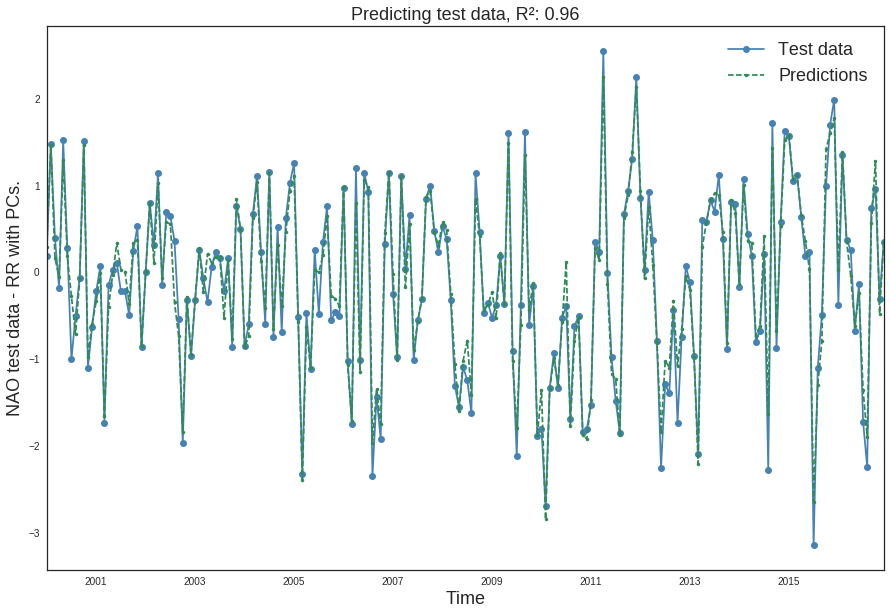

In [16]:
# Plot the predictions on test data
plot_predictions(y_test, predictions_test, score_test, '{} test data - RR with PCs.'.format(INDEX,500))

## Spatial maps

Trying to plot in a similar way as shown here, eg for EA: http://www.cpc.ncep.noaa.gov/data/teledoc/telecontents.shtml

In [17]:



x_train_flat = np.reshape(x_train_raw, (x_train_raw.shape[0], -1))
x_test_flat = np.reshape(x_test_raw, (x_test_raw.shape[0], -1))## Function to make average pressure anomaly composite maps
## This for selective months of interest (4) and for test and predicted sample
## Mainly for comparison of spatial patterns between the two.

def plotStereo(hgtdata,obsindex,modindex,indexname,phase='positive',monthlist=[1,4,7,10]):
    
    if phase=='positive':
        selIndObs = np.where(obsindex > 0)
        selIndMod = np.where(modindex > 0)
    else:
        selIndObs = np.where(obsindex < 0)
        selIndMod = np.where(modindex < 0)
        
    dataObs = hgtdata.sel(time=data.time.values[selIndObs]).groupby('time.month').mean('time')
    dataMod = hgtdata.sel(time=data.time.values[selIndMod]).groupby('time.month').mean('time')
    
    
    bounds = [-2,-1.5,-1,-0.5,0.5,1,1.5,2]
    cmap = sns.diverging_palette(240, 10, n=7, as_cmap=True)
    norm = colors.BoundaryNorm(bounds, cmap.N)
    extend="min"

    plt.figure(figsize=(15,8))
    
    o = dataObs['hgt'].sel(month=[1,4,7,10]).plot(transform=ccrs.PlateCarree(), col='month',
                                  subplot_kws={'projection': ccrs.Orthographic(-50, 75)},
                                  extend="both",vmin=-2,vmax=2,cmap=cmap,norm=norm)

    for ax in o.axes.flat:
        ax.coastlines(linewidth=1.2,color='0.3')
        ax.gridlines()
        
    figtitle1 = figdir + indexname.replace("/", "") + "_spatialmap_test_"+phase+".png"
    plt.savefig(figtitle1,dpi=150,bbox_inches='tight')
        
    plt.figure(figsize=(15,8))
    
    m = dataMod['hgt'].sel(month=[1,4,7,10]).plot(transform=ccrs.PlateCarree(), col='month',
                                  subplot_kws={'projection': ccrs.Orthographic(-50, 75)},
                                  extend="both",vmin=-2,vmax=2,cmap=cmap,norm=norm)

    for ax in m.axes.flat:
        ax.coastlines(linewidth=1.2,color='0.3')
        ax.gridlines()
        
    #plt.show()
    figtitle2 = figdir + indexname.replace("/", "") + "_spatialmap_prediction_"+phase+".png"
    plt.savefig(figtitle2,dpi=150,bbox_inches='tight')
    
    figtitle3 = figdir + indexname.replace("/", "") + "_spatialmaps_"+phase+".png"
    ## Stack images together
    os.system("convert -append " +
              figtitle1 + " " +
              figtitle2 + " " +
              figtitle3)

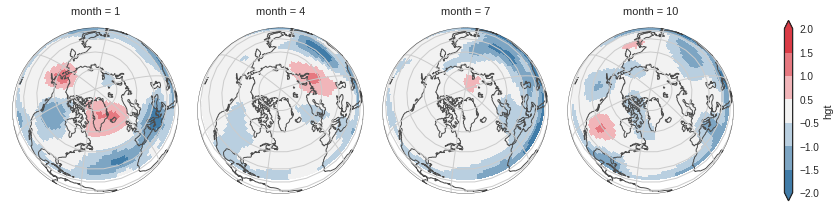

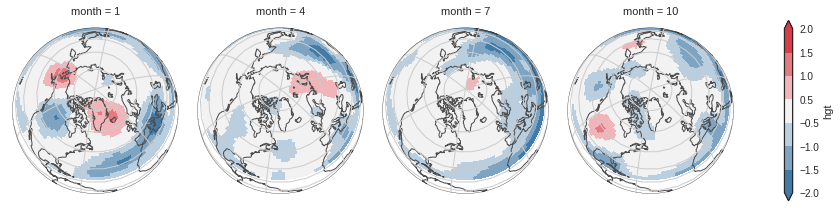

In [18]:
plotStereo(data,y_test,predictions_test,phase='negative',indexname=INDEX)

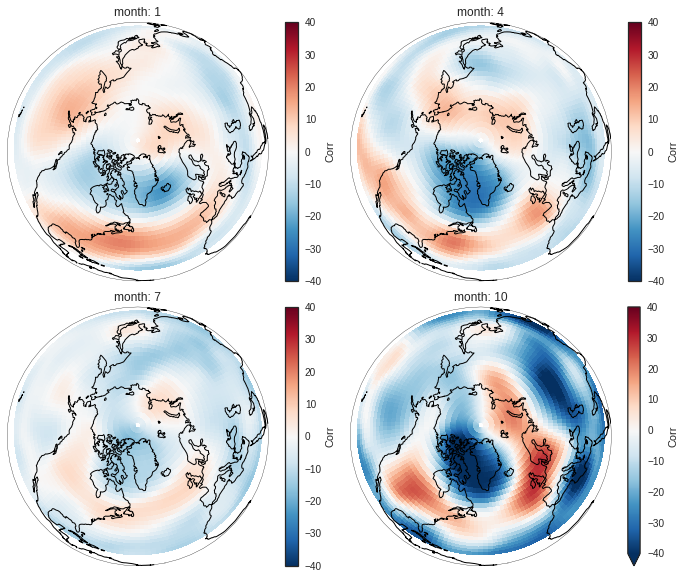

In [19]:
## Plot correlation matrix between index ~ height anomaly series
## Correlation is calculated per pixel: for specific month and positive values
## Months are: January, April, July, October

monthlist = [0,3,6,9]

fig = plt.figure(figsize=(12,10))
fig.subplots_adjust(hspace=0.1, wspace=0.05)

for pp in np.arange(1,5,1):
    
    posOK = np.where(indices[INDEX] > 0)[0].tolist()
    monOK = np.arange(monthlist[pp-1],len(indices[INDEX]),12).tolist() 
    allOK = np.sort(list(set(posOK).intersection(monOK)))

    ## Select proper index time serie values
    obsOK = indices[INDEX].iloc[allOK]

    ## Select same time steps from pressure anomalies
    dataOK = data.sel(time=data.time.values[allOK])
    datarr = dataOK.hgt.drop('level').values

    corr = np.full([datarr.shape[2], datarr.shape[3]], np.nan)

    for ii in range(datarr.shape[2]):
        for jj in range(datarr.shape[3]):
            corr[ii,jj] = np.correlate(obsOK,datarr[:,0,ii,jj])

    corr_xr = xr.Dataset({'Corr': (['lat', 'lon'],  corr)},
                                coords={'lat': data.lat, 'lon': data.lon})

    #z_min, z_max = -np.abs(corr).max(), np.abs(corr).max()
    z_min, z_max = -40,40
    
    ax = fig.add_subplot(2,2,pp, projection=ccrs.Orthographic(-50,85), aspect='auto')
    corr_xr.Corr.plot(ax=ax, transform=ccrs.PlateCarree(),add_colorbar=True,vmin=z_min,vmax=z_max,cmap="RdBu_r")
    ax.set_global(); ax.coastlines();
    ax.set_title('month: '+str(monthlist[pp-1]+1))

plt.savefig(figdir+ INDEX.replace("/", "") + '_corrmap.jpg')

## Plot the PCA loadings

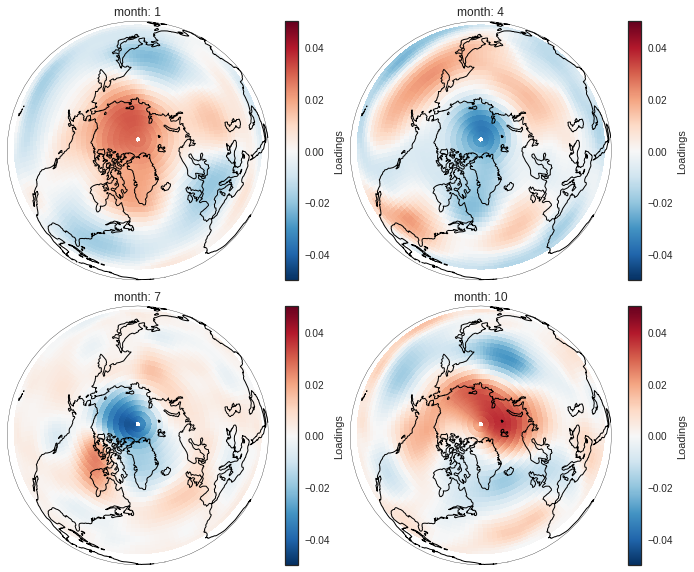

In [20]:
from sklearn.decomposition import PCA

n_comp=20
pca = PCA(n_components=n_comp)

n_train = len(y_train_raw)
n_test = len(y_test_raw)

fig = plt.figure(figsize=(12,10))
fig.subplots_adjust(hspace=0.1, wspace=0.05)

# Select component
component = 0

for i, month in enumerate([1, 4, 7,10]):
    
    # Select data from one month
    x_train_month = x_train_flat[train_month == month]
    
    # Fit PCA
    pca.fit(x_train_month)
    
    # Plot loadings for the first component
    
    ax = fig.add_subplot(2,2,i+1, projection=ccrs.Orthographic(-50,85), aspect='auto')
    
    plotdata =  xr.Dataset({'Loadings': (['lat', 'lon'],
                                         pca.components_[component,:].reshape((x_train_raw.shape[1], x_train_raw.shape[2])))},
                                coords={'lat': data.lat, 'lon': data.lon})

    z_min, z_max = -0.05,0.05
    plotdata.Loadings.plot(ax=ax,
                           transform=ccrs.PlateCarree(),
                           add_colorbar=True,
                           vmin=z_min,vmax=z_max,
                           cmap="RdBu_r")
    ax.set_global()
    ax.coastlines()
    ax.set_title('month: {}'.format(month))

# PART 2: Validation 

In [21]:
# Read in three datasets:
# 1. ncep_hgt_anom:  data used to calculate NOAA index
# 2. era20c = reanalysis dataset, 1900-2010
# 3. zg_amon = model output, 1976-2015

ncep_hgt_anom = xr.open_dataset('./hgt.mon.mean_stdanom.nc')
era20c = xr.open_dataset('./data/era20c_hgt.mon.mean_stdanom.nc')
zg_amon = xr.open_dataset('./data/zg_Amon_CESM1-BGC_historical_r1i1p1_185001-200512.500_stdanom.nc')

ncep_hgt_anom

<xarray.Dataset>
Dimensions:  (lat: 29, level: 1, lon: 144, time: 813)
Coordinates:
  * lon      (lon) float32 -180.0 -177.5 -175.0 -172.5 -170.0 -167.5 -165.0 ...
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 77.5 75.0 72.5 70.0 67.5 ...
  * level    (level) float64 500.0
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 1950-03-01 ...
Data variables:
    hgt      (time, level, lat, lon) float64 -0.2456 -0.2456 -0.2456 -0.2456 ...
Attributes:
    CDI: Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    history: Thu Oct 05 11:58:29 2017: cdo -div /home/maffie/data/coi/NCEP/step4.nc -timstd /home/maffie/data/coi/NCEP/step4.nc /home/maffie/data/coi/NCEP/hgt.mon.mean_stdanom.nc
Thu Oct 05 11:58:28 2017: cdo -sub /home/maffie/data/coi/NCEP/step2.nc /home/maffie/data/coi/NCEP/step3.nc /home/maffie/data/coi/NCEP/step4.nc
Thu Oct 05 11:58:28 2017: cdo ymonmean -selyear,1981/2010 /home/maffie/data/coi/NCEP/step2.nc /home/maffie/data/coi/NCEP/step3.nc
Thu Oct 05 11:58:

## 1. Validate the method on the training data with cross-validation

In [22]:
INDEX = 'WP'


# NAO: North Atlantic Oscillation
# EA: East Atlantic Pattern
# WP: West Pacific Pattern
# EP/NP: EastPacific/ North Pacific Pattern 
# PNA: Pacific/ North American Pattern 
# EA/WR: East Atlantic/West Russia Pattern
# SCA: Scandinavia Pattern 
# TNH: Tropical/ Northern Hemisphere Pattern
# POL: Polar/ Eurasia Pattern
# PT: Pacific Transition Pattern 

y_raw = indices[INDEX].values
index_missing = indices[INDEX].isnull()
y_series = indices[INDEX][~index_missing]

# Input data:
x_raw = np.squeeze(np.array(ncep_hgt_anom['hgt'].sel(time=slice('1950',None))))
x_flat = np.reshape(x_raw, (x_raw.shape[0], -1))

# Remove missing entries
y = y_raw[~index_missing.values]
x = x_flat[~index_missing.values]

To validate the method on the ```ncep_hgt_anom``` data, we will use 5-fold blocked cross-validation:

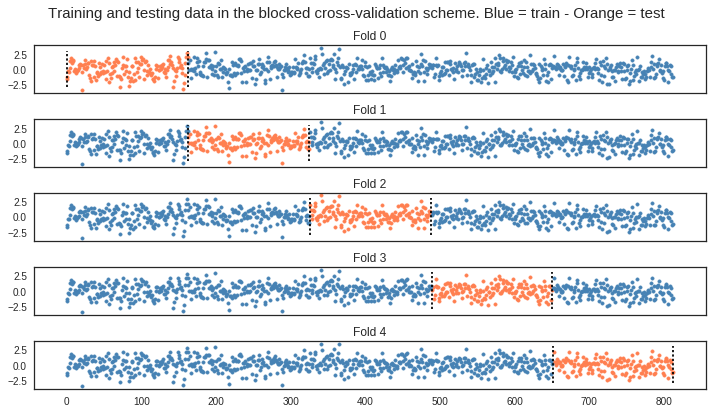

In [23]:
from sklearn.model_selection import KFold
n_splits = 5

kf = KFold(n_splits=n_splits, shuffle=False)

fig, axes = plt.subplots(nrows=n_splits, figsize=(10,6), sharex=True)

cmap = matplotlib.cm.get_cmap('nipy_spectral')
 
for i, (train_index, test_index) in enumerate(kf.split(y)):
    axes[i].scatter(test_index, y[test_index], color='coral', marker='.')
    axes[i].scatter(train_index, y[train_index], color='steelblue', marker='.')
    axes[i].set_title('Fold {}'.format(i))
    axes[i].vlines(x=min(test_index), ymin=-3, ymax=3, linestyle=':')
    axes[i].vlines(x=max(test_index), ymin=-3, ymax=3, linestyle=':')
fig.suptitle('Training and testing data in the blocked cross-validation scheme. Blue = train - Orange = test').set_fontsize(15)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])


Note the difference with random cross-validation, which we cannot use here because of temporal autocorrelation between train and test samples:

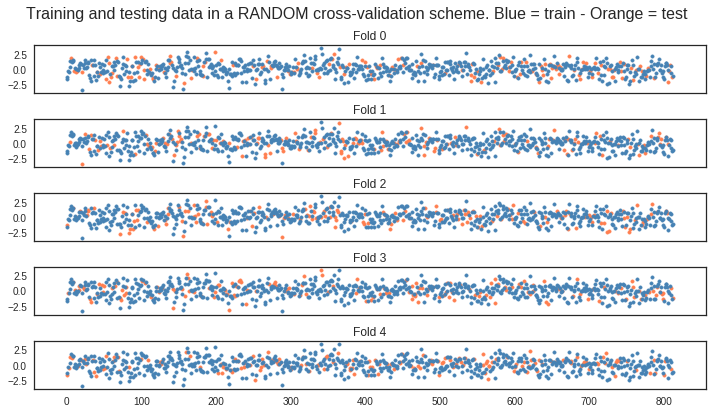

In [24]:
from sklearn.model_selection import KFold
n_splits = 5

kf = KFold(n_splits=n_splits, shuffle=True)

fig, axes = plt.subplots(nrows=n_splits, figsize=(10,6), sharex=True)

cmap = matplotlib.cm.get_cmap('nipy_spectral')
 
for i, (train_index, test_index) in enumerate(kf.split(y)):
    axes[i].scatter(test_index, y[test_index], color='coral', marker='.')
    axes[i].scatter(train_index, y[train_index], color='steelblue', marker='.')
    axes[i].set_title('Fold {}'.format(i))
fig.suptitle('Training and testing data in a RANDOM cross-validation scheme. Blue = train - Orange = test').set_fontsize(16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])


Now, for each fold, train the PCRR model on the training data and make predictions for the test data:

In [25]:
kf = KFold(n_splits=n_splits, shuffle=False)

# Store the predictions and R² score for each fold
test_predictions = []
scores = []

first_obs = [] # Keep track of the first observation of each fold to make plot 

# Loop over the different folds
for i, (train_index, test_index) in enumerate(kf.split(y)):
   
    # Define train and test data for this fold
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]
    first_obs.append(min(test_index))
    
    # Get month indexes
    train_month = y_series[train_index].index.month
    test_month = y_series[test_index].index.month
   
    # Loop over the months (the model is fitted per month)
    indices_per_month = []
    predictions_per_month = []

    for m in np.unique(train_month):
        model = PCRR()
       
        y_train_month = y_train[train_month == m]
        x_train_month = x_train[train_month == m]
        x_test_month = x_test[test_month == m]
        
        model.fit(x_train_month, y_train_month)
        
        indices_per_month.append(test_index[test_month == m])
        predictions_per_month.append(model.predict(x_test_month))

    # Flatten the indices per month and the predictions per month for this fold into two lists
    test_indices = [item for sublist in indices_per_month for item in sublist]
    unsorted_predictions = [item for sublist in predictions_per_month for item in sublist]
    
    # Sort the predictions for this fold according to the indices
    sorted_predictions = ([t for _,t in sorted(zip(test_indices,unsorted_predictions))])
    
    score = r2_score(y_test, sorted_predictions)
    print('Fold {} of {}, score: {}'.format(i, n_splits,score))
          
    scores.append(score)
    test_predictions.append(sorted_predictions)

complete_predictions = list(np.hstack(test_predictions))
avg_score = np.round(np.mean(scores),2)
print('Average score: {}'.format(avg_score))

Fold 0 of 5, score: 0.923746369589
Fold 1 of 5, score: 0.96071257357
Fold 2 of 5, score: 0.93923011411
Fold 3 of 5, score: 0.964394528649
Fold 4 of 5, score: 0.961047519095
Average score: 0.95


Plot the predictions for the complete dataset:

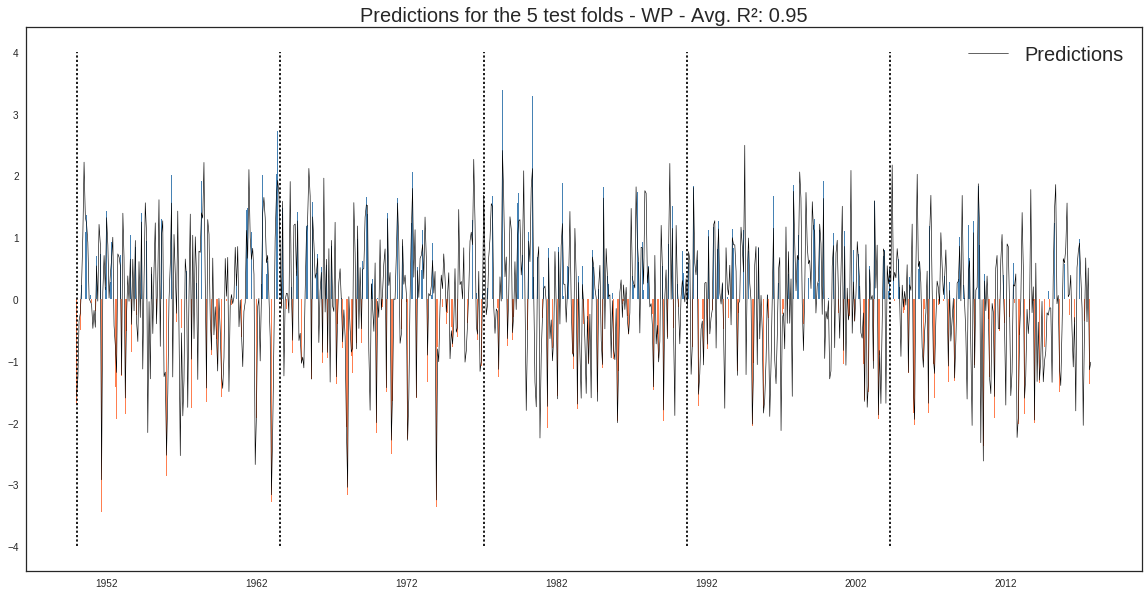

In [26]:
fig, ax = plt.subplots(figsize=(20,10))

x = y_series.index.values[:]
y = y_series.values[:]

width = 10
ax.bar(x[y>0], y[y>0], lw=2, width=width, color='steelblue')
ax.bar(x[y<0], y[y<0], lw=2, width=width, color='coral')
ax.plot(y_series.index.values[:], complete_predictions[:], lw=0.6, color='black')
ax.set_title('Predictions for the 5 test folds - {} - Avg. R²: {}'.format(INDEX, avg_score)).set_fontsize(20)
ax.legend(['Predictions'], prop={'size': 20})
# Indicate the fold splits
for f in first_obs:
    ax.vlines(x=y_series.index[f], ymin = -4, ymax=4, linestyle=':')

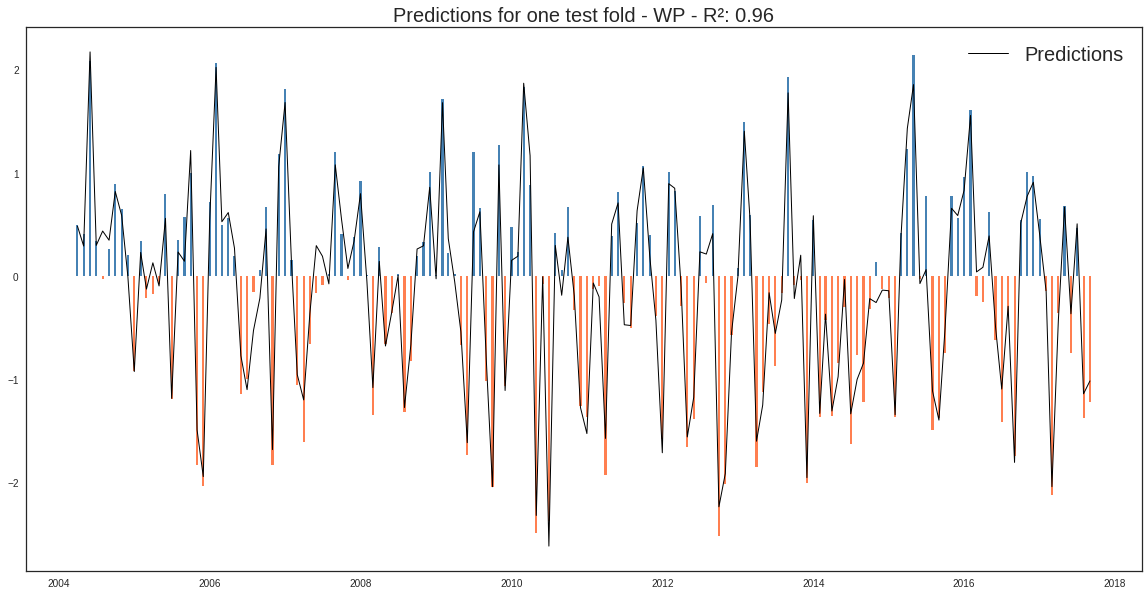

In [27]:
fig, ax = plt.subplots(figsize=(20,10))

start_index = 651
x = y_series.index.values[start_index:]
y = y_series.values[start_index:]

width = 10
ax.bar(x[y>0], y[y>0], lw=2, width=width, color='steelblue')
ax.bar(x[y<0], y[y<0], lw=2, width=width, color='coral')
ax.plot(y_series.index.values[start_index:], complete_predictions[start_index:], lw=1, color='black')
ax.set_title('Predictions for one test fold - {} - R²: {:.2f}'.format(INDEX, scores[-1])).set_fontsize(20)
ax.legend(['Predictions'], prop={'size': 20})
# Indicate the fold splits
#for f in first_obs:
#    ax.vlines(x=y_series.index[f], ymin = -4, ymax=4, linestyle=':')


## 2. Generate predictions for the reanalysis dataset ```era20c```

In [43]:
ncep_hgt_anom

<xarray.Dataset>
Dimensions:  (lat: 29, level: 1, lon: 144, time: 813)
Coordinates:
  * lon      (lon) float32 -180.0 -177.5 -175.0 -172.5 -170.0 -167.5 -165.0 ...
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 77.5 75.0 72.5 70.0 67.5 ...
  * level    (level) float64 500.0
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 1950-03-01 ...
Data variables:
    hgt      (time, level, lat, lon) float64 -0.2456 -0.2456 -0.2456 -0.2456 ...
Attributes:
    CDI: Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    history: Thu Oct 05 11:58:29 2017: cdo -div /home/maffie/data/coi/NCEP/step4.nc -timstd /home/maffie/data/coi/NCEP/step4.nc /home/maffie/data/coi/NCEP/hgt.mon.mean_stdanom.nc
Thu Oct 05 11:58:28 2017: cdo -sub /home/maffie/data/coi/NCEP/step2.nc /home/maffie/data/coi/NCEP/step3.nc /home/maffie/data/coi/NCEP/step4.nc
Thu Oct 05 11:58:28 2017: cdo ymonmean -selyear,1981/2010 /home/maffie/data/coi/NCEP/step2.nc /home/maffie/data/coi/NCEP/step3.nc
Thu Oct 05 11:58:

Roll the era20c data so that both datasets are centered on the same point

In [44]:
era20c = xr.open_dataset('./data/era20c_hgt.mon.mean_stdanom.nc')
era20c_rolled = xr.Dataset(data_vars = {'hgt':(['time', 'lat', 'lon'], 
                                            era20c.roll(longitude=144/2)['z'].values)},
                           coords={'lat': ncep_hgt_anom.lat,
                                    'lon': ncep_hgt_anom.lon,
                                      'time': era20c.time}
                            )

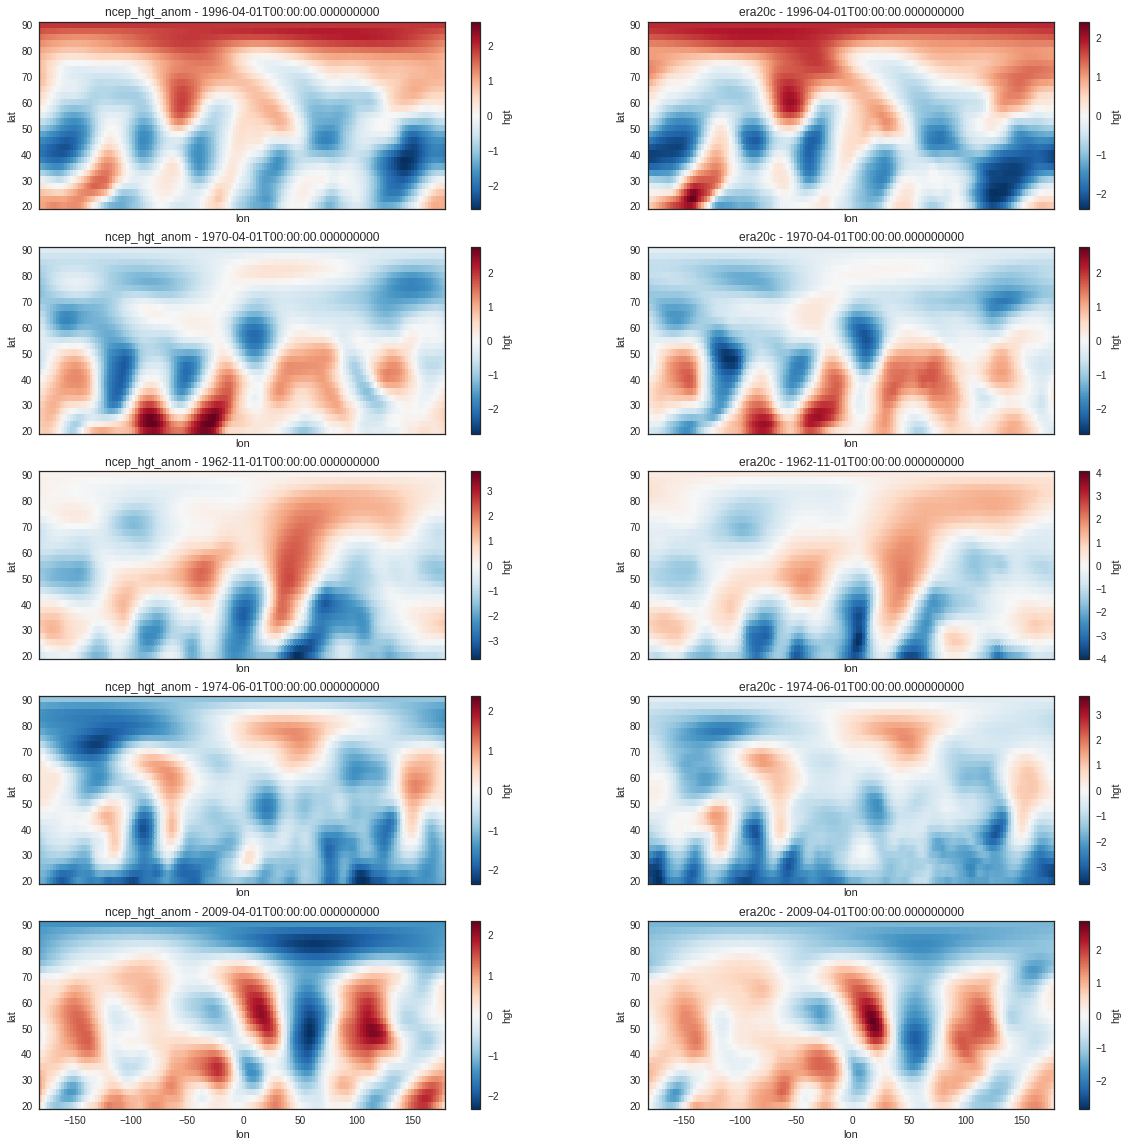

In [45]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20,20), sharex=True)

for axrow in axes:
    timestamp = np.random.choice(ncep_hgt_anom.time.sel(time=slice('1950','2010')).values)
    ncep_hgt_anom.sel(time=timestamp)['hgt'].plot(ax=axrow[0])
    era20c_rolled.sel(time=timestamp)['hgt'].plot(ax=axrow[1])
    axrow[0].set_title('ncep_hgt_anom - {}'.format(timestamp))
    axrow[1].set_title('era20c - {}'.format(timestamp))

We will once again loop over all the months, train the PCRR on the entire ```ncep_hgt_anom``` dataset (now that we have validated it with CV), and make predictions for the ```era20c``` dataset:

In [46]:
# Pick an index to predict:
INDEX = 'PT' 

# NAO: North Atlantic Oscillation
# EA: East Atlantic Pattern
# WP: West Pacific Pattern
# EP/NP: EastPacific/ North Pacific Pattern 
# PNA: Pacific/ North American Pattern 
# EA/WR: East Atlantic/West Russia Pattern
# SCA: Scandinavia Pattern 
# TNH: Tropical/ Northern Hemisphere Pattern
# POL: Polar/ Eurasia Pattern
# PT: Pacific Transition Pattern 

y_raw = indices[INDEX].values
index_missing = indices[INDEX].isnull()
y_series = indices[INDEX][~index_missing]

# Training data:
x_raw = np.squeeze(np.array(ncep_hgt_anom['hgt'].sel(time=slice('1950',None))))
x_flat = np.reshape(x_raw, (x_raw.shape[0], -1))

# Remove missing entries
y_train = y_raw[~index_missing.values]
x_train = x_flat[~index_missing.values]

# Test data: 
# x_test_raw = np.squeeze(np.array(era20c['z']))
x_test_raw = np.squeeze(np.array(era20c_rolled['hgt']))
x_test_flat = np.reshape(x_test_raw, (x_test_raw.shape[0], -1))
x_test = x_test_flat

In [47]:
predictions_test = np.zeros(len(x_test))# predictions

train_month = y_series.index.month
test_month = [pd.to_datetime(item).month for item in era20c.time.values]

# Loop over the months
for m in tqdm(np.sort(np.unique(train_month))):
        model = PCRR()
       
        y_train_month = y_train[train_month == m]
        x_train_month = x_train[train_month == m]
        x_test_month = x_test[test_month == m]
        
        model.fit(x_train_month, y_train_month)
        
        predictions_test[test_month == m] = model.predict(x_test_month)

100%|██████████| 2/2 [00:00<00:00, 10.68it/s]


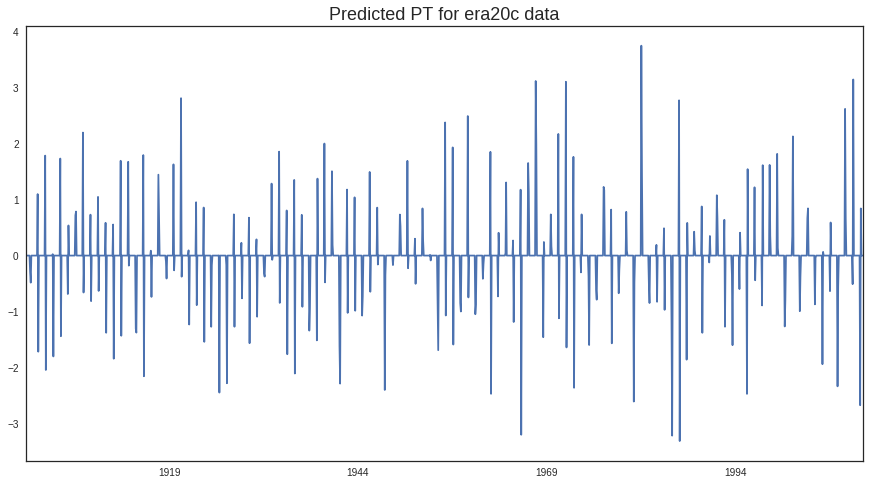

In [48]:
fig, ax = plt.subplots(figsize=(15,8))
pd.Series(predictions_test, index=era20c.time.values).plot(ax=ax)
ax.set_title('Predicted {} for era20c data'.format(INDEX)).set_fontsize(18)

Does it correspond with the observed index (which is based on a different set of anomalies) during the time period in which they overlap?

In [49]:
correlation = np.corrcoef(y_series[:'2010'].values, pd.Series(predictions_test, index=era20c.time.values)['1950':].reindex(y_series[:'2010'].index))
correlation

array([[ 1.        ,  0.92613829],
       [ 0.92613829,  1.        ]])

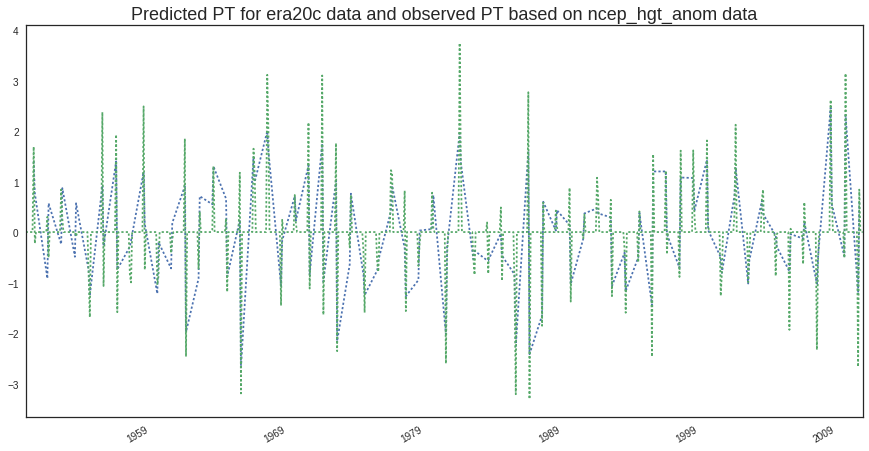

In [50]:
fig, ax = plt.subplots(figsize=(15,8))
y_series[:'2010'].plot(ax=ax, style=':')
pd.Series(predictions_test, index=era20c.time.values)['1950':].plot(ax=ax, style=':')
ax.set_title('Predicted {} for era20c data and observed {} based on ncep_hgt_anom data'.format(INDEX,INDEX)).set_fontsize(18)


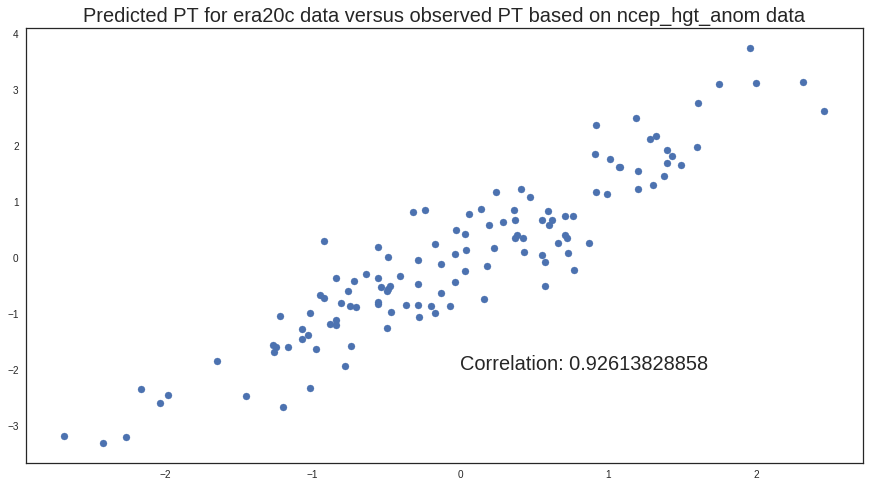

In [51]:
fig, ax = plt.subplots(figsize=(15,8))
ax.scatter(y_series[:'2010'].values, pd.Series(predictions_test, index=era20c.time.values)['1950':].reindex(y_series[:'2010'].index).values)
ax.set_title('Predicted {} for era20c data versus observed {} based on ncep_hgt_anom data'.format(INDEX,INDEX)).set_fontsize(20)
ax.text(0, -2, 'Correlation: {}'.format(correlation[1,0])).set_fontsize(20)

## 3. Generate predictions for model-based dataset ```zg_amon``` en for observations `era20c`

In [28]:
zg_amon = xr.open_dataset('./data/zg500hpa_Amon_CESM1-BGC_historical_r1i1p1_185001-200512_stdanom_remapped.nc')

era20c = xr.open_dataset('./data/era20c_hgt.mon.mean_stdanom_remapped.nc')
era20c

<xarray.Dataset>
Dimensions:  (lat: 29, lon: 144, time: 1332)
Coordinates:
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 12.5 15.0 17.5 20.0 22.5 ...
  * lat      (lat) float64 90.0 87.5 85.0 82.5 80.0 77.5 75.0 72.5 70.0 67.5 ...
  * time     (time) datetime64[ns] 1900-01-01 1900-02-01 1900-03-01 ...
Data variables:
    z        (time, lat, lon) float64 0.3291 0.3291 0.3291 0.3291 0.3291 ...
Attributes:
    CDI: Climate Data Interface version ?? (http://mpimet.mpg.de/cdi)
    Conventions: CF-1.6
    history: Tue Nov 14 11:54:49 2017: cdo remapbil,ncep_grid.txt era20c_hgt.mon.mean_stdanom.nc era20c_hgt.mon.mean_stdanom_remapped.nc
Fri Oct 20 15:15:24 2017: cdo -P 4 -b 64 -div /media/voLhwm/EXT/data/ERA20c/hgt.mon.mean_anom.nc /media/voLhwm/EXT/data/ERA20c/refstd.nc /media/voLhwm/EXT/data/ERA20c/hgt.mon.mean_stdanom.nc
Fri Oct 20 15:15:23 2017: cdo -P 4 -b 64 -ymonstd /media/voLhwm/EXT/data/ERA20c/ref.nc /media/voLhwm/EXT/data/ERA20c/refstd.nc
Fri Oct 20 15:14:56 2017: cdo -P 4 -b 64 

In [29]:
zg_amon.time

<xarray.DataArray 'time' (time: 1872)>
array(['1850-01-16T12:00:00.000000000', '1850-02-15T00:00:00.000000000',
       '1850-03-16T12:00:00.000000000', ..., '2005-10-16T12:00:00.000000000',
       '2005-11-16T00:00:00.000000000', '2005-12-16T12:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T12:00:00 1850-02-15 ...
Attributes:
    standard_name: time
    long_name: time
    bounds: time_bnds
    axis: T

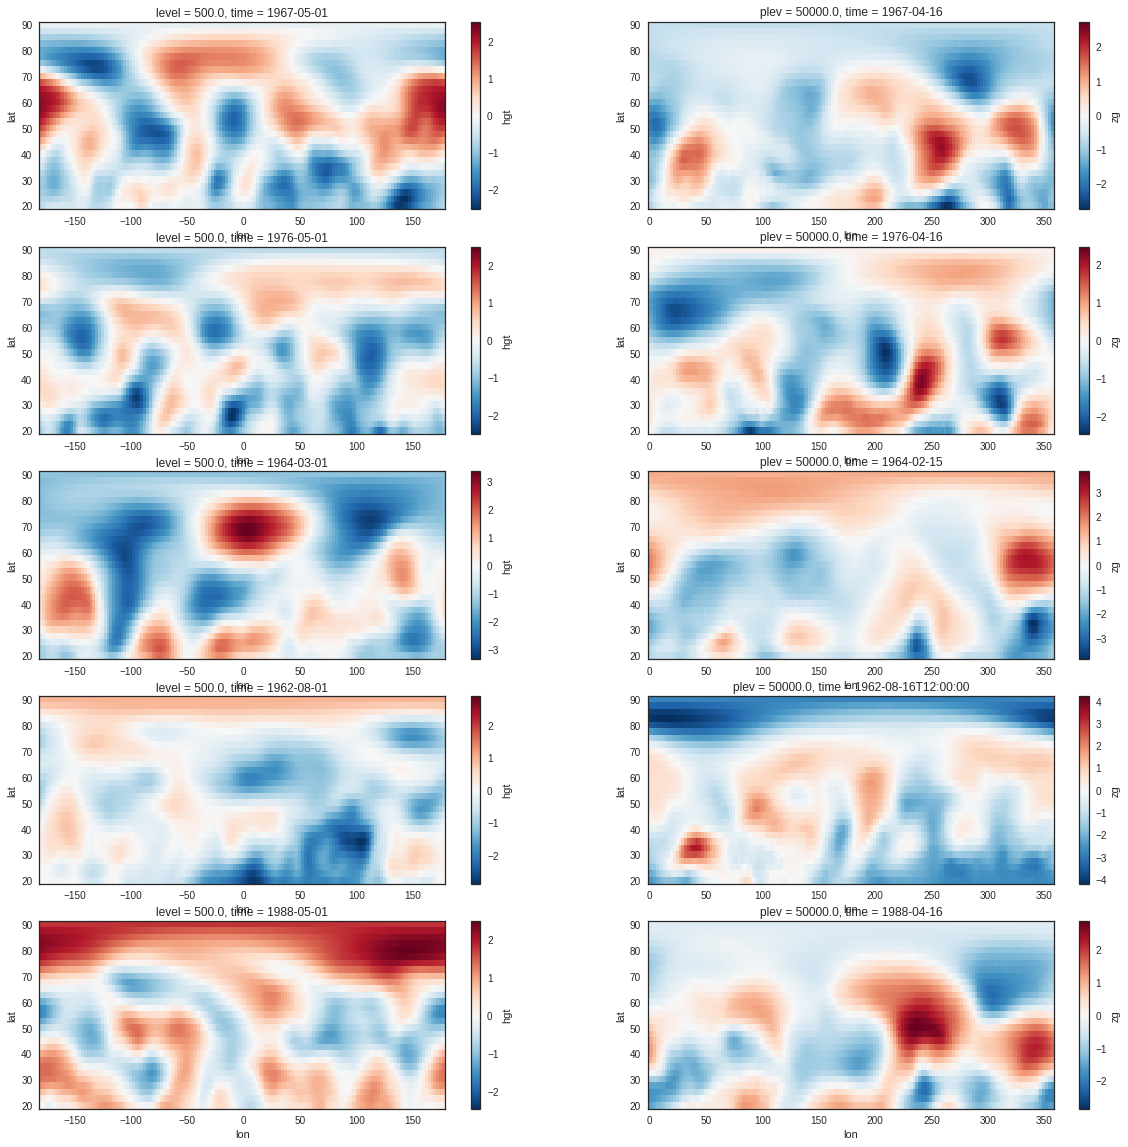

In [61]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(20,20))

for axrow in axes:
    timestamp = np.random.choice(ncep_hgt_anom.time.sel(time=slice('1950','2004')).values)
    ncep_hgt_anom.sel(time=timestamp)['hgt'].plot(ax=axrow[0])
    zg_amon.sel(time=timestamp, method='nearest')['zg'].plot(ax=axrow[1])

Same procedure as before

In [30]:
# Indices to predict:

# NAO: North Atlantic Oscillation
# EA: East Atlantic Pattern
# WP: West Pacific Pattern
# EP/NP: EastPacific/ North Pacific Pattern 
# PNA: Pacific/ North American Pattern 
# EA/WR: East Atlantic/West Russia Pattern
# SCA: Scandinavia Pattern 
# TNH: Tropical/ Northern Hemisphere Pattern
# POL: Polar/ Eurasia Pattern
# PT: Pacific Transition Pattern 

indices_list = ['NAO','PNA','SCA','TNH','PT', 'EP/NP', 'EA/WR', 'WP', 'POL', 'EA']
pred_dict = {}# store predictions in list

100%|██████████| 10/10 [00:10<00:00,  1.12s/it]


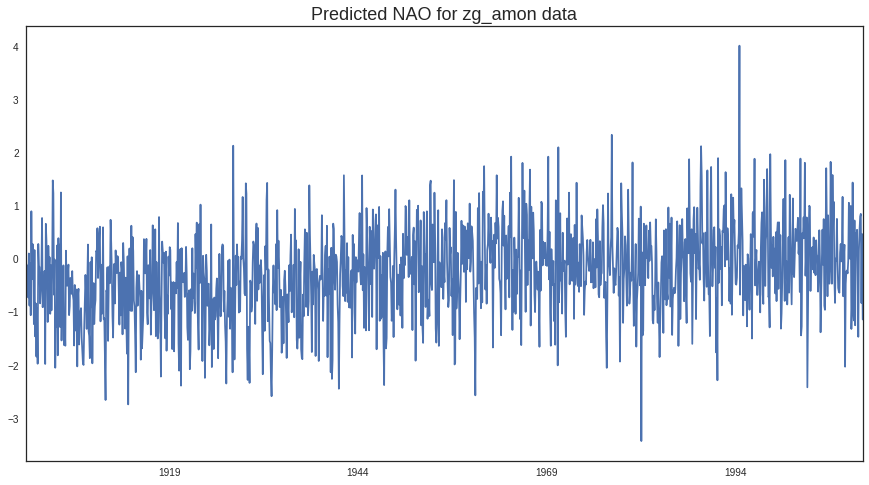

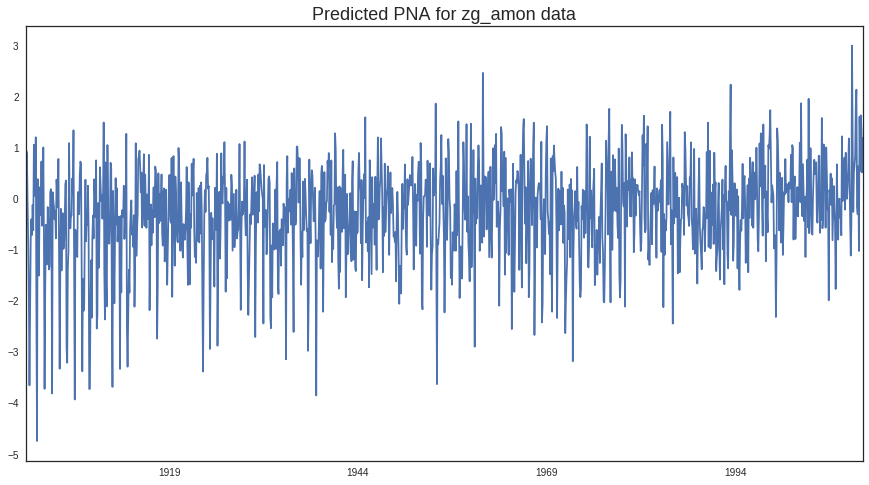

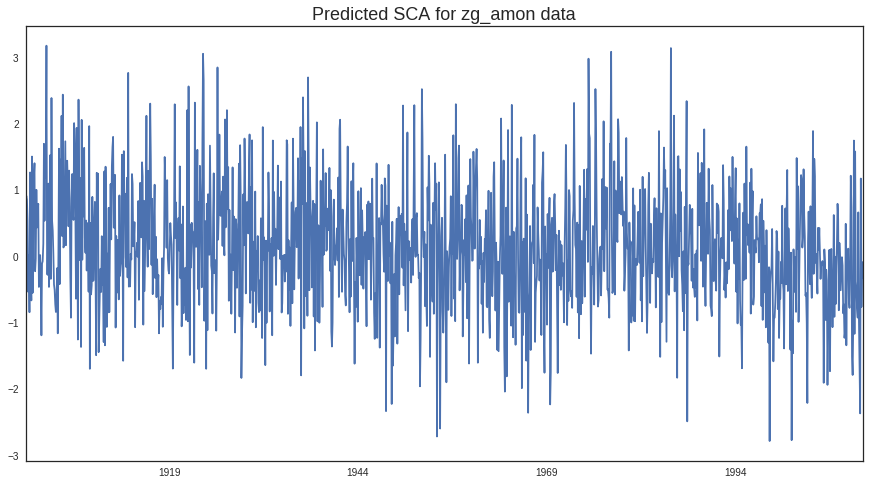

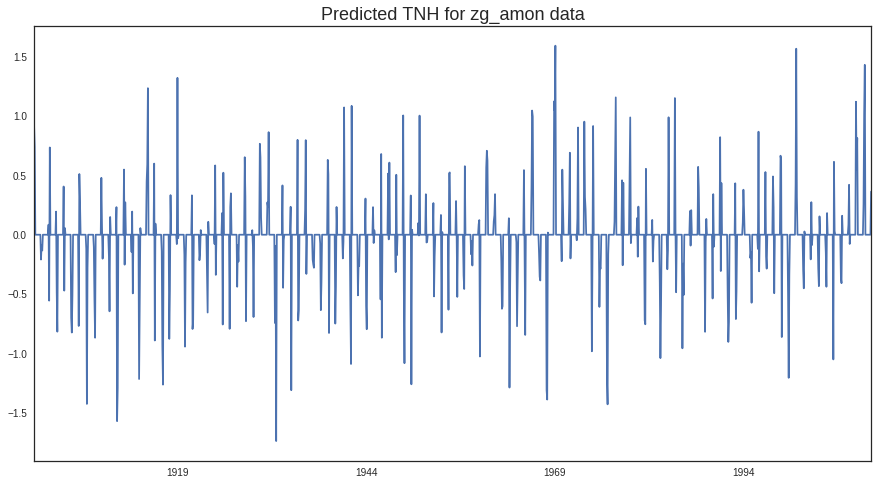

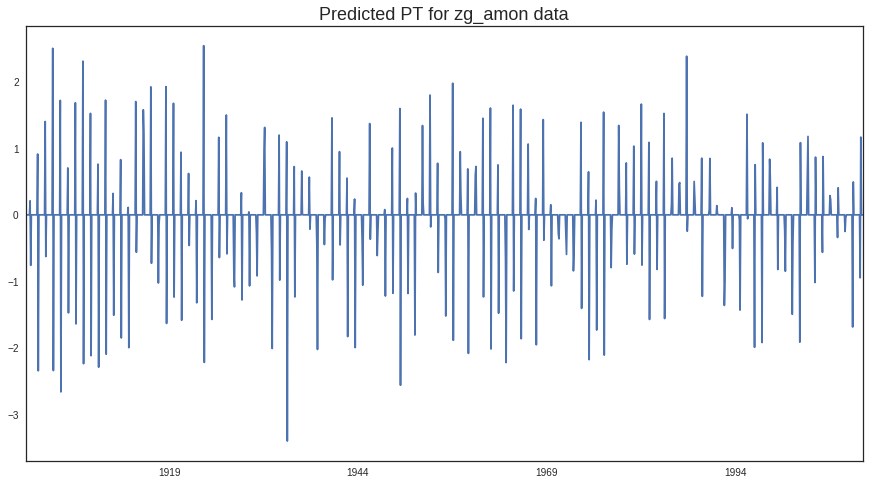

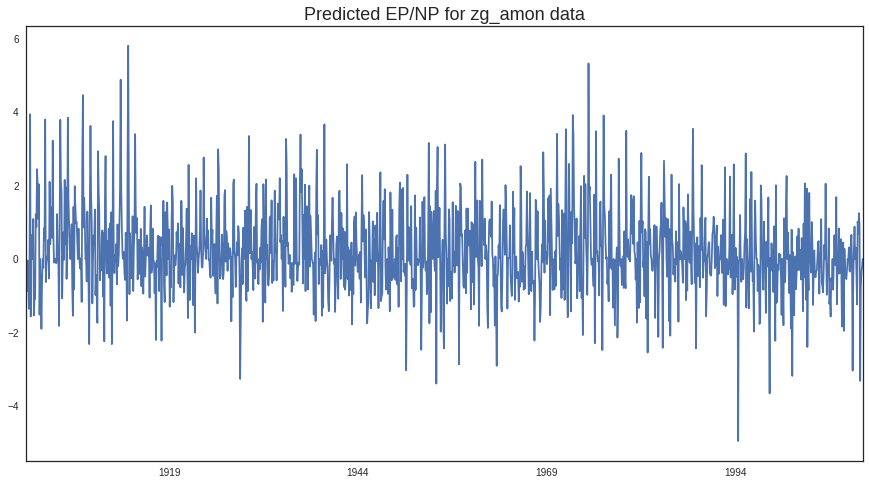

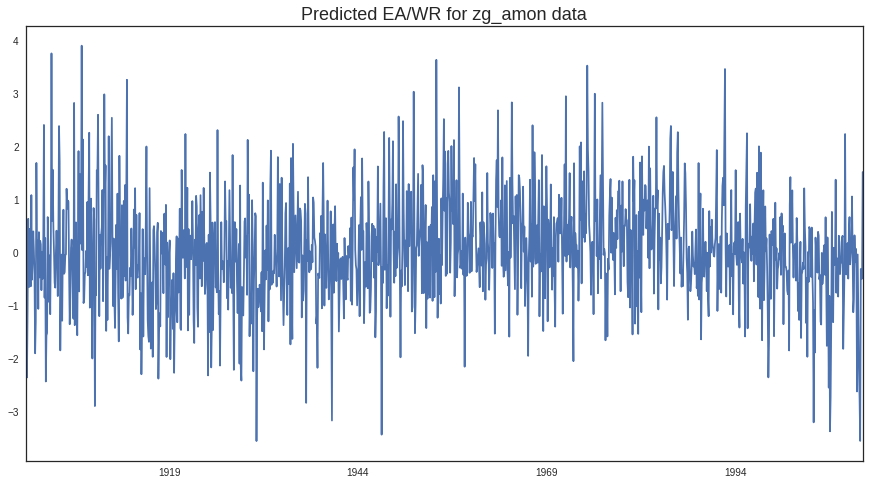

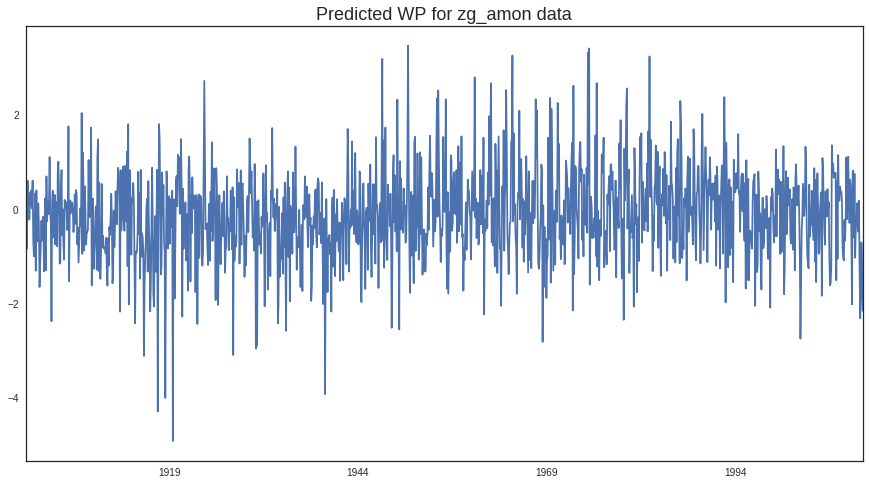

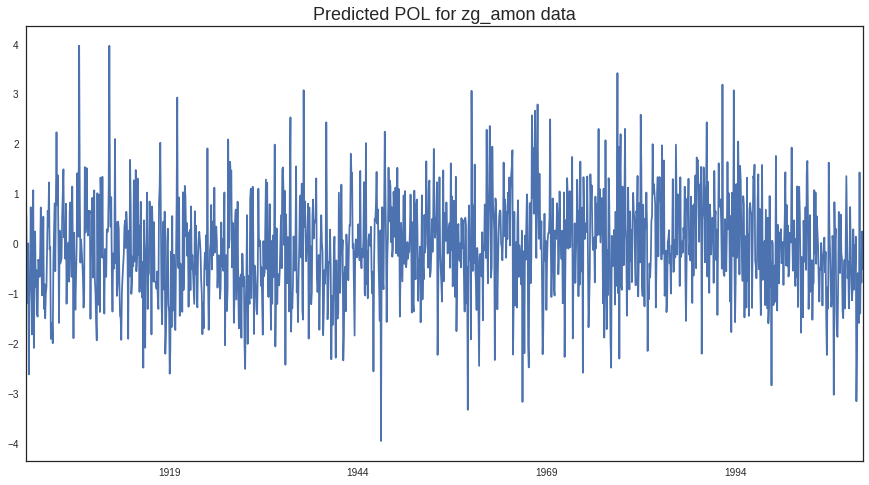

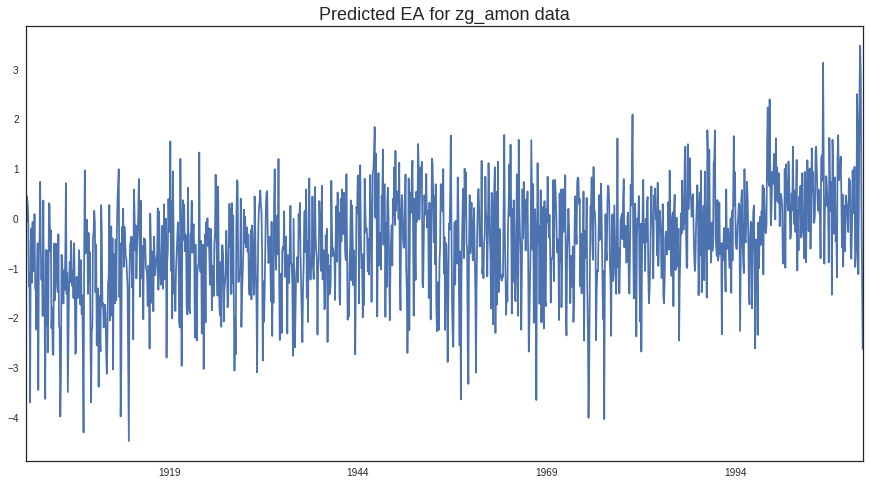

In [33]:
for INDEX in tqdm(indices_list):

    y_raw = indices[INDEX].values
    index_missing = indices[INDEX].isnull()
    y_series = indices[INDEX][~index_missing]

    # Training data:
    x_raw = np.squeeze(np.array(ncep_hgt_anom['hgt'].sel(time=slice('1950',None))))
    x_flat = np.reshape(x_raw, (x_raw.shape[0], -1))

    # Remove missing entries
    y_train = y_raw[~index_missing.values]
    x_train = x_flat[~index_missing.values]

    # Test data: 
    x_test_raw = np.squeeze(np.array(era20c['z']))
    x_test_flat = np.reshape(x_test_raw, (x_test_raw.shape[0], -1))
    x_test = x_test_flat
    
    predictions_test = np.zeros(len(x_test))# predictions

    train_month = y_series.index.month
    test_month = [pd.to_datetime(item).month for item in era20c.time.values]

    # Loop over the months
    for m in np.unique(train_month):
            model = PCRR()

            y_train_month = y_train[train_month == m]
            x_train_month = x_train[train_month == m]
            x_test_month = x_test[test_month == m]

            model.fit(x_train_month, y_train_month)

            predictions_test[test_month == m] = model.predict(x_test_month)
            pred_dict[INDEX] = predictions_test
    fig, ax = plt.subplots(figsize=(15,8))
    pd.Series(predictions_test, index=era20c.time.values).plot(ax=ax)
    ax.set_title('Predicted {} for zg_amon data'.format(INDEX)).set_fontsize(18)

In [34]:
# Store as .csv
results = pd.DataFrame(pred_dict, index=era20c.time.values)
results.head()

EA     EA/WR     EP/NP       NAO       PNA       POL   PT  \
1900-01-01  0.587892 -0.166963  1.396283 -0.558327 -0.219499  0.865817  0.0   
1900-02-01 -0.081044 -1.274326 -0.512175 -0.094860  0.941731  0.530274  0.0   
1900-03-01  0.452745 -2.351269 -0.880082 -0.250813  0.890568 -1.185387  0.0   
1900-04-01  0.313923 -1.097123 -0.041577 -0.126810 -0.090749 -0.762196  0.0   
1900-05-01  0.068956  0.639747 -0.442715 -0.722758 -0.831685  0.012602  0.0   

                 SCA       TNH        WP  
1900-01-01  0.841738  0.925682 -0.172970  
1900-02-01  0.915881  0.738490  0.221929  
1900-03-01  0.857833  0.000000 -0.832395  
1900-04-01  0.536342  0.000000  0.605989  
1900-05-01 -0.533284  0.000000  0.072148

In [35]:
results.to_csv('/home/stijndc/Desktop/code_repositories/climate_indices/predictions_era20c.csv')